In [1]:
import pandas as pd
import numpy as np

In [59]:
# read dms demo result
demo = "1A0N.pdb_E24S"
demo_path = f"../data/dms/results/{demo}_esm2_t48_15B_UR50D_esm1v_5_.csv"
demo_df = pd.read_csv(demo_path)
for idx, row in demo_df.iterrows():
    if row["mut"] != "WT":
        row["mut"] = row["mut"][0] + str(int(row["mut"][1:-1])-1) + row["mut"][-1]
    row["sequence"] = row["sequence"][1:]
    demo_df.loc[idx, :] = row
demo_df.head()

,comment,mut,sequence,fitness
0,mutations: S25E probability: 2.7233,S24E,VTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,2.723295
1,mutations: S25D probability: 2.3909,S24D,VTLFVALYDYEARTEDDLSFHKGDKFQILNSSEGDWWEARSLTTGE...,2.390868
2,mutations: S32K probability: 0.0227,S31K,VTLFVALYDYEARTEDDLSFHKGSKFQILNKSEGDWWEARSLTTGE...,0.022677
3,mutations: WT probability: 0.0000,WT,VTLFVALYDYEARTEDDLSFHKGSKFQILNSSEGDWWEARSLTTGE...,0.000000
4,mutations: S25Q probability: -0.4421,S24Q,VTLFVALYDYEARTEDDLSFHKGQKFQILNSSEGDWWEARSLTTGE...,-0.442090


In [60]:
# read dms demo ground truth
demo_gt_path = f"../data/dms/dms/{demo}.json"
import json
demo_gt_json = json.load(open(demo_gt_path))

wt_fitness = None
mutations = []
for site in demo_gt_json:
    for mut in demo_gt_json[site]:
        if mut[0] == site[0]:
            if wt_fitness is None:
                wt_fitness = mut[1]
                mutations.append(("WT", 0))
        elif len(mut[0]) == 1:
            mutations.append((site+mut[0], mut[1]-wt_fitness))
demo_gt_df = pd.DataFrame(mutations, columns=["mut", "gt_fitness"]).sort_values("gt_fitness", ascending=False)
demo_gt_df

,mut,gt_fitness
303,D17Q,2.051075
304,D17E,1.991338
716,E38Y,1.823067
440,S24D,1.794281
717,E38F,1.786517
...,...,...
1029,V55R,-3.629058
61,F4D,-3.635309
479,F26R,-3.699166
482,F26S,-3.787191


In [61]:
demo_merged_df = demo_df.merge(demo_gt_df, on="mut",how="outer").sort_values("fitness", ascending=False)
demo_merged_df.head()

,comment,mut,sequence,fitness,gt_fitness
0,mutations: S25E probability: 2.7233,S24E,VTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,2.723295,1.684310
1,mutations: S25D probability: 2.3909,S24D,VTLFVALYDYEARTEDDLSFHKGDKFQILNSSEGDWWEARSLTTGE...,2.390868,1.794281
2,mutations: S32K probability: 0.0227,S31K,VTLFVALYDYEARTEDDLSFHKGSKFQILNKSEGDWWEARSLTTGE...,0.022677,0.125503
3,mutations: WT probability: 0.0000,WT,VTLFVALYDYEARTEDDLSFHKGSKFQILNSSEGDWWEARSLTTGE...,0.000000,0.000000
4,mutations: S25Q probability: -0.4421,S24Q,VTLFVALYDYEARTEDDLSFHKGQKFQILNSSEGDWWEARSLTTGE...,-0.442090,0.637205


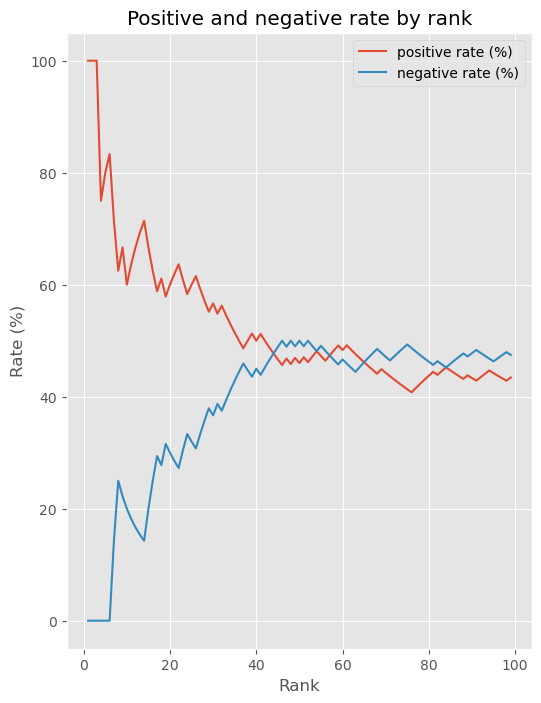

In [81]:
# count the number of mutations in CD and no CD by rank
count_results = []
for rank in range(1, 100):
    positive_count = (demo_merged_df.iloc[:rank, :]["gt_fitness"] > 0).sum()
    negative_count = (demo_merged_df.iloc[:rank, :]["gt_fitness"] < 0).sum()
    count_results.append((rank, positive_count/rank*100, negative_count/rank*100))
count_results = pd.DataFrame(count_results, columns=["rank", "positive", "negative"])
# plot a fine figure
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# change legend name
count_results = count_results.rename(columns={"positive": "positive rate (%)", "negative": "negative rate (%)"})
count_results.plot(x="rank", y=["positive rate (%)", "negative rate (%)"], figsize=(6, 8), ylabel="Rate (%)", xlabel="Rank", title="Positive and negative rate by rank")
plt.savefig("2_figs/2_mainfig_a.svg", bbox_inches='tiPght')
plt.savefig("2_figs/2_mainfig_a.pdf", bbox_inches='tight')